### Import

In [ ]:
import argparse, time

import dgl
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgi import Classifier, DGI
from dgl import DGLGraph
from dgl.data import load_data, register_data_args

In [6]:
from tqdm import tqdm
import pandas as pd

from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
import hdbscan

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.13 ms (started: 2023-05-15 12:51:48 -05:00)


In [3]:
import sys
sys.path.append("../../")

from Utils_TM.utils import *

/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/li

time: 3.4 s (started: 2023-05-15 12:50:48 -05:00)


In [4]:
torch.manual_seed(42)
np.random.seed(42)

time: 3.71 ms (started: 2023-05-14 16:31:48 -05:00)


In [7]:
def evaluate(model, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

time: 1.17 ms (started: 2023-05-15 12:51:48 -05:00)


### Test DGI

In [189]:
parser = argparse.ArgumentParser(description="DGI")
# register_data_args(parser)
parser.add_argument(
    "--dataset",
    type=str,
    default="cora",
    required=False,
    help="The input dataset. Can be cora, citeseer, pubmed, syn(synthetic dataset) or reddit",
)
parser.add_argument(
    "--dropout", type=float, default=0.0, help="dropout probability"
)
parser.add_argument("--gpu", type=int, default=-1, help="gpu")
parser.add_argument(
    "--dgi-lr", type=float, default=1e-3, help="dgi learning rate"
)
parser.add_argument(
    "--classifier-lr",
    type=float,
    default=1e-2,
    help="classifier learning rate",
)
parser.add_argument(
    "--n-dgi-epochs",
    type=int,
    default=300,
    help="number of training epochs",
)
parser.add_argument(
    "--n-classifier-epochs",
    type=int,
    default=300,
    help="number of training epochs",
)
parser.add_argument(
    "--n-hidden", type=int, default=8, help="number of hidden gcn units"
)
parser.add_argument(
    "--n-layers", type=int, default=3, help="number of hidden gcn layers"
)
parser.add_argument(
    "--weight-decay", type=float, default=0.0, help="Weight for L2 loss"
)
parser.add_argument(
    "--patience", type=int, default=20, help="early stop patience condition"
)
parser.add_argument(
    "--self-loop",
    action="store_true",
    help="graph self-loop (default=False)",
)
parser.set_defaults(self_loop=False)
args = parser.parse_args("")
print(args)

Namespace(dataset='cora', dropout=0.0, gpu=-1, dgi_lr=0.001, classifier_lr=0.01, n_dgi_epochs=300, n_classifier_epochs=300, n_hidden=8, n_layers=3, weight_decay=0.0, patience=20, self_loop=False)


In [190]:
data = load_data(args)
g = data[0]
g

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [7]:
# load and preprocess dataset
data = load_data(args)
g = data[0]
print("x", g)

features = torch.FloatTensor(g.ndata["feat"])
print(features.shape)
labels = torch.LongTensor(g.ndata["label"])
if hasattr(torch, "BoolTensor"):
    train_mask = torch.BoolTensor(g.ndata["train_mask"])
    val_mask = torch.BoolTensor(g.ndata["val_mask"])
    test_mask = torch.BoolTensor(g.ndata["test_mask"])
else:
    train_mask = torch.ByteTensor(g.ndata["train_mask"])
    val_mask = torch.ByteTensor(g.ndata["val_mask"])
    test_mask = torch.ByteTensor(g.ndata["test_mask"])
in_feats = features.shape[1]
n_classes = data.num_classes
n_edges = g.num_edges()

if args.gpu < 0:
    cuda = False
else:
    cuda = True
    torch.cuda.set_device(args.gpu)
    features = features.cuda()
    labels = labels.cuda()
    train_mask = train_mask.cuda()
    val_mask = val_mask.cuda()
    test_mask = test_mask.cuda()

# add self loop
if args.self_loop:
    g = dgl.remove_self_loop(g)
    g = dgl.add_self_loop(g)
n_edges = g.num_edges()

if args.gpu >= 0:
    g = g.to(args.gpu)
# create DGI model
dgi = DGI(
    g,
    in_feats,
    args.n_hidden,
    args.n_layers,
    nn.PReLU(args.n_hidden),
    args.dropout,
)

if cuda:
    dgi.cuda()

dgi_optimizer = torch.optim.Adam(
    dgi.parameters(), lr=args.dgi_lr, weight_decay=args.weight_decay
)

# train deep graph infomax
cnt_wait = 0
best = 1e9
best_t = 0
dur = []
for epoch in range(args.n_dgi_epochs):
    dgi.train()
    if epoch >= 3:
        t0 = time.time()

    dgi_optimizer.zero_grad()
    loss = dgi(features)
    loss.backward()
    dgi_optimizer.step()

    if loss < best:
        best = loss
        best_t = epoch
        cnt_wait = 0
        torch.save(dgi.state_dict(), "best_dgi.pkl")
    else:
        cnt_wait += 1

    if cnt_wait == args.patience:
        print("Early stopping!")
        break

    if epoch >= 3:
        dur.append(time.time() - t0)

    """ print(
        "Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | "
        "ETputs(KTEPS) {:.2f}".format(
            epoch, np.mean(dur), loss.item(), n_edges / np.mean(dur) / 1000
        )
    ) """

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
x Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})
torch.Size([2708, 1433])


/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [8]:
import pandas as pd
embeds = dgi.encoder(features, corrupt=False)
embeds = embeds.detach()

df_node_embeddings = pd.DataFrame(data=embeds)
df_node_embeddings

/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


,0,1,2,3,4,5,6,7
0,0.037034,0.070822,0.868612,0.346374,0.286196,0.642375,0.714926,0.136939
1,0.241429,0.296999,0.650953,0.226868,0.458752,0.477815,0.597382,0.413789
2,0.056121,0.093133,0.916942,0.321737,0.337438,0.662987,0.789948,0.177604
3,-0.019822,0.320573,0.586570,0.459211,0.368667,0.397008,0.609787,0.465533
4,0.150068,0.199800,0.709929,0.295895,0.374031,0.520438,0.624449,0.266853
...,...,...,...,...,...,...,...,...
2703,0.100332,0.144679,0.799203,0.315164,0.345508,0.589813,0.686782,0.218628
2704,0.138999,0.181891,0.748054,0.299811,0.369181,0.554278,0.656666,0.257245
2705,0.025082,0.047659,0.916816,0.340090,0.285041,0.670006,0.754570,0.121314
2706,0.015724,0.063308,0.930193,0.349550,0.294802,0.681167,0.775913,0.144066


In [5]:
import sys
sys.path.append("../../../../")

from Utils_TM.utils import *

/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/li

In [14]:
list_df_reduction_embeddings, list_reduction_embeddings_legend = reduction_embeddings([df_node_embeddings], [""], n_component=2)

In [9]:
# visualization_pseudo_cluster_embeddings(list_df_reduction_embeddings, titles=list_reduction_embeddings_legend, cols=3)

0


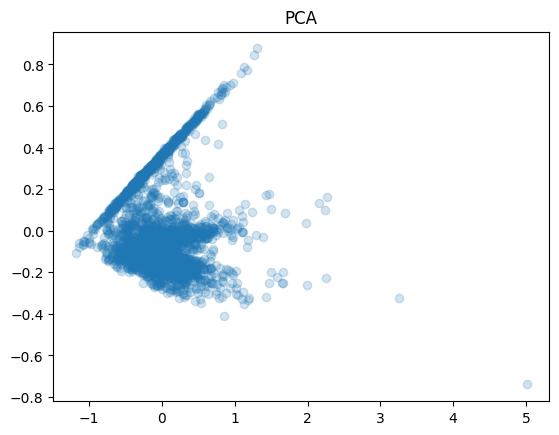

1


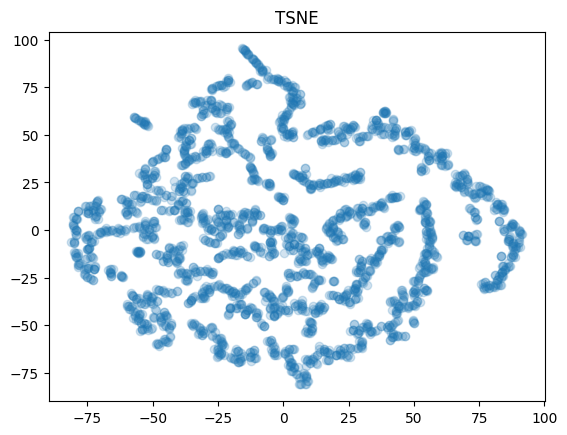

2


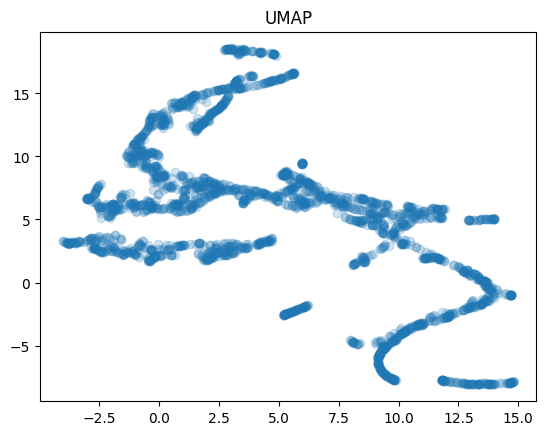

In [15]:
import matplotlib.pyplot as plt
reduction = ["PCA", "TSNE", "UMAP"]
for k in range(len(list_df_reduction_embeddings)):
    print(k)
    x = list_df_reduction_embeddings[k].iloc[:, 0]
    y = list_df_reduction_embeddings[k].iloc[:, 1]
    # plt.scatter(x, y, c=list_df_reduction_embeddings[k]["labels"].values, alpha=0.2)
    plt.scatter(x, y, alpha=0.2)
    
    plt.title(reduction[k])
    plt.show()

---

### 1. Data preprocessing

In [8]:
dir = "/home/ealvarez/GNN_Filter"

time: 501 µs (started: 2023-05-15 12:51:48 -05:00)


In [6]:
# Read dataset

group = [("WT", 5), ("zwf1^", 3), ("pck1^", 2)]
group = group[2]
print(group)


('pck1^', 2)
time: 956 µs (started: 2023-05-14 16:31:48 -05:00)


In [7]:
# Load dataset Groups
df1 = pd.read_csv("{}/inputs/Edwin_proyecto2/{}.csv".format(dir, "int1"), delimiter="|")
df2 = pd.read_csv("{}/inputs/Edwin_proyecto2/{}.csv".format(dir, "int2"), delimiter="|")
df3 = pd.read_csv("{}/inputs/Edwin_proyecto2/{}.csv".format(dir, "int3"), delimiter="|")
df4 = pd.read_csv("{}/inputs/Edwin_proyecto2/{}.csv".format(dir, "int4"), delimiter="|")
# df5_ = pd.read_csv("{}/inputs/Edwin_proyecto2/{}.csv".format(dir, "int5"), delimiter="|")

""" df1 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities1"), delimiter="|")
df2 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities2"), delimiter="|")
df3 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities3"), delimiter="|")
df4 = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities4"), delimiter="|")
df5_ = pd.read_csv("{}/inputs/SecondDataset/{}.csv".format(dir, "intensities5"), delimiter="|") """

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
# print(df5_.shape)

(6245, 102)
(6245, 72)
(6245, 97)
(6245, 137)
time: 225 ms (started: 2023-05-14 16:31:48 -05:00)


In [8]:
# concat
# df_join_raw = pd.concat([df1.iloc[:,1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:], df5.iloc[:, 2:]], axis=1)
df_join_raw = pd.concat([df1.iloc[:, 1:], df2.iloc[:, 2:], df3.iloc[:, 2:], df4.iloc[:, 2:]], axis=1)
df_join_raw.set_index("ionMz", inplace=True)

print(df_join_raw.shape)
df_join_raw

(6245, 400)


,0001 / zwf1^ 3.4,0002 / zwf1^ 3.4,0003 / zwf1^ 3.4,0004 / zwf1^ 3.4,0005 / zwf1^ 3.4,0006 / zwf1^ 3.4,0007 / zwf1^ 3.4,0008 / zwf1^ 3.4,0009 / zwf1^ 3.4,0010 / zwf1^ 3.4,...,0951 / WT 3.4,0952 / WT 3.4,0953 / WT 3.4,0954 / WT 3.4,0955 / WT 3.4,0956 / WT 3.4,0957 / WT 3.4,0958 / WT 3.4,0959 / WT 3.4,0960 / WT 3.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1,47,508,360,675,232,59,345,346,504,...,45,817,32,307,410,716,228,187,361,952
59.0137,53182,57902,51861,62812,54291,54395,59054,52547,57544,63538,...,45747,39677,47205,38697,54320,62610,47283,49927,43632,48511
59.0291,2151,2102,2334,2864,2393,2246,2331,1954,2310,2528,...,1852,1717,1830,1660,2006,2539,2103,2276,1643,2522
59.0370,83,174,366,1134,693,464,235,479,443,691,...,225,349,185,429,186,278,364,368,115,887
59.0453,1,1,51,642,493,143,11,227,160,154,...,60,293,1,336,65,142,1,182,10,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2470,2435,2465,2727,2773,2157,2168,2623,2256,2636,...,1866,1834,1669,674,2533,1017,2983,1814,2160,1899
996.7096,3366,3241,2909,3469,3538,3010,3031,2872,2709,3601,...,1748,1419,1160,621,1758,1474,1973,1023,1769,1629
997.5542,2818,2335,1807,1679,2222,2070,2158,1835,2087,2784,...,1168,828,1162,1103,2253,1419,2306,1542,827,1433


time: 42.2 ms (started: 2023-05-14 16:31:49 -05:00)


In [9]:
# get WT groud
df_wt = df_join_raw.filter(regex="WT", axis=1)

print(df_wt.shape)
df_wt

(6245, 200)


,0071 / WT 2.2,0072 / WT 2.2,0073 / WT 2.2,0074 / WT 2.2,0075 / WT 2.2,0076 / WT 2.2,0077 / WT 2.2,0078 / WT 2.2,0079 / WT 2.2,0080 / WT 2.2,...,0951 / WT 3.4,0952 / WT 3.4,0953 / WT 3.4,0954 / WT 3.4,0955 / WT 3.4,0956 / WT 3.4,0957 / WT 3.4,0958 / WT 3.4,0959 / WT 3.4,0960 / WT 3.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,528,1,378,438,530,250,662,431,305,334,...,45,817,32,307,410,716,228,187,361,952
59.0137,56523,24625,78586,76559,67449,74919,88152,99718,86001,93962,...,45747,39677,47205,38697,54320,62610,47283,49927,43632,48511
59.0291,2290,927,3149,3038,2774,3419,3911,3820,3374,3746,...,1852,1717,1830,1660,2006,2539,2103,2276,1643,2522
59.0370,320,195,1137,642,588,799,602,606,768,372,...,225,349,185,429,186,278,364,368,115,887
59.0453,196,59,555,405,234,413,46,148,95,25,...,60,293,1,336,65,142,1,182,10,684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2050,1415,3851,2285,2038,3089,2737,2788,1819,2600,...,1866,1834,1669,674,2533,1017,2983,1814,2160,1899
996.7096,2681,1984,3570,2169,2479,2668,3033,3271,2264,2411,...,1748,1419,1160,621,1758,1474,1973,1023,1769,1629
997.5542,1516,1307,2299,2363,2877,1436,1771,2326,1629,2740,...,1168,828,1162,1103,2253,1419,2306,1542,827,1433


time: 30.6 ms (started: 2023-05-14 16:31:49 -05:00)


In [10]:
# get ZW groud
df_zw = df_join_raw.filter(like="zwf1^")

print(df_zw.shape)
df_zw

(6245, 120)


,0001 / zwf1^ 3.4,0002 / zwf1^ 3.4,0003 / zwf1^ 3.4,0004 / zwf1^ 3.4,0005 / zwf1^ 3.4,0006 / zwf1^ 3.4,0007 / zwf1^ 3.4,0008 / zwf1^ 3.4,0009 / zwf1^ 3.4,0010 / zwf1^ 3.4,...,0861 / zwf1^ 1.4,0862 / zwf1^ 1.4,0863 / zwf1^ 1.4,0864 / zwf1^ 1.4,0865 / zwf1^ 1.4,0866 / zwf1^ 1.4,0867 / zwf1^ 1.4,0868 / zwf1^ 1.4,0869 / zwf1^ 1.4,0870 / zwf1^ 1.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1,47,508,360,675,232,59,345,346,504,...,344,790,851,372,899,752,54,254,145,1236
59.0137,53182,57902,51861,62812,54291,54395,59054,52547,57544,63538,...,134377,133636,129520,122223,133150,129628,127563,116371,114443,118647
59.0291,2151,2102,2334,2864,2393,2246,2331,1954,2310,2528,...,5207,5676,5416,5091,5594,5638,5234,4746,4308,5475
59.0370,83,174,366,1134,693,464,235,479,443,691,...,939,946,1195,700,1071,1302,993,857,412,1348
59.0453,1,1,51,642,493,143,11,227,160,154,...,225,168,398,84,76,516,127,351,1,753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,2470,2435,2465,2727,2773,2157,2168,2623,2256,2636,...,1647,3001,2639,2850,2716,2415,2060,2886,2558,2891
996.7096,3366,3241,2909,3469,3538,3010,3031,2872,2709,3601,...,2002,3333,2695,2343,2433,2471,2424,2671,2323,2457
997.5542,2818,2335,1807,1679,2222,2070,2158,1835,2087,2784,...,2782,2553,2499,1393,2354,2002,2307,2151,2031,1425


time: 29.4 ms (started: 2023-05-14 16:31:49 -05:00)


In [11]:
# get pc groud
df_pc = df_join_raw.filter(like="pck1^")

print(df_pc.shape)
df_pc

(6245, 80)


,0011 / pck1^ 2.4,0012 / pck1^ 2.4,0013 / pck1^ 2.4,0014 / pck1^ 2.4,0015 / pck1^ 2.4,0016 / pck1^ 2.4,0017 / pck1^ 2.4,0018 / pck1^ 2.4,0019 / pck1^ 2.4,0020 / pck1^ 2.4,...,0881 / pck1^ 2.3,0882 / pck1^ 2.3,0883 / pck1^ 2.3,0884 / pck1^ 2.3,0885 / pck1^ 2.3,0886 / pck1^ 2.3,0887 / pck1^ 2.3,0888 / pck1^ 2.3,0889 / pck1^ 2.3,0890 / pck1^ 2.3
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,901,81,377,488,883,426,421,689,383,222,...,857,655,431,335,200,670,256,288,315,427
59.0137,33968,22565,36285,30275,34858,28558,36375,31684,25583,24293,...,59883,65860,65463,64715,52758,56120,60780,64502,62149,66849
59.0291,1947,945,2010,1776,1806,1549,2015,1494,1399,1029,...,2528,3118,2863,2896,2422,2483,2878,3035,2456,2964
59.0370,644,139,752,607,694,685,681,404,619,117,...,522,911,995,655,740,733,652,693,697,724
59.0453,139,78,352,414,373,388,376,353,345,134,...,181,459,429,155,321,257,342,135,315,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,1169,923,815,1219,638,1161,1461,1710,1224,947,...,1580,1340,1940,1714,1266,735,828,1709,978,1051
996.7096,1122,1767,1914,1748,1575,1599,1738,1701,2425,1651,...,1330,817,1456,1113,816,520,161,1229,596,447
997.5542,1135,1849,1313,819,1883,1296,964,1236,1117,711,...,1111,1401,467,2230,1664,1296,391,587,883,762


time: 22.2 ms (started: 2023-05-14 16:31:49 -05:00)


In [12]:
# Logarithm

if group[0] == "WT": # Unable this line when it's run by group
  df_join_raw = df_wt.copy()
elif group[0] == "zwf1^":
  df_join_raw = df_zw.copy()
elif group[0] == "pck1^":
  df_join_raw = df_pc.copy()

df_raw_log = df_join_raw.copy()
for column in df_join_raw.columns:
  df_raw_log[column] = np.log10(df_join_raw[column])

df_raw_log

/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,0011 / pck1^ 2.4,0012 / pck1^ 2.4,0013 / pck1^ 2.4,0014 / pck1^ 2.4,0015 / pck1^ 2.4,0016 / pck1^ 2.4,0017 / pck1^ 2.4,0018 / pck1^ 2.4,0019 / pck1^ 2.4,0020 / pck1^ 2.4,...,0881 / pck1^ 2.3,0882 / pck1^ 2.3,0883 / pck1^ 2.3,0884 / pck1^ 2.3,0885 / pck1^ 2.3,0886 / pck1^ 2.3,0887 / pck1^ 2.3,0888 / pck1^ 2.3,0889 / pck1^ 2.3,0890 / pck1^ 2.3
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,2.954725,1.908485,2.576341,2.688420,2.945961,2.629410,2.624282,2.838219,2.583199,2.346353,...,2.932981,2.816241,2.634477,2.525045,2.301030,2.826075,2.408240,2.459392,2.498311,2.630428
59.0137,4.531070,4.353435,4.559727,4.481084,4.542302,4.455728,4.560803,4.500840,4.407951,4.385481,...,4.777304,4.818622,4.815996,4.811005,4.722288,4.749118,4.783761,4.809573,4.793434,4.825095
59.0291,3.289366,2.975432,3.303196,3.249443,3.256718,3.190051,3.304275,3.174351,3.145818,3.012415,...,3.402777,3.493876,3.456821,3.461799,3.384174,3.394977,3.459091,3.482159,3.390228,3.471878
59.0370,2.808886,2.143015,2.876218,2.783189,2.841359,2.835691,2.833147,2.606381,2.791691,2.068186,...,2.717671,2.959518,2.997823,2.816241,2.869232,2.865104,2.814248,2.840733,2.843233,2.859739
59.0453,2.143015,1.892095,2.546543,2.617000,2.571709,2.588832,2.575188,2.547775,2.537819,2.127105,...,2.257679,2.661813,2.632457,2.190332,2.506505,2.409933,2.534026,2.130334,2.498311,2.618048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,3.067815,2.965202,2.911158,3.086004,2.804821,3.064832,3.164650,3.232996,3.087781,2.976350,...,3.198657,3.127105,3.287802,3.234011,3.102434,2.866287,2.918030,3.232742,2.990339,3.021603
996.7096,3.049993,3.247237,3.281942,3.242541,3.197281,3.203848,3.240050,3.230704,3.384712,3.217747,...,3.123852,2.912222,3.163161,3.046495,2.911690,2.716003,2.206826,3.089552,2.775246,2.650308
997.5542,3.054996,3.266937,3.118265,2.913284,3.274850,3.112605,2.984077,3.092018,3.048053,2.851870,...,3.045714,3.146438,2.669317,3.348305,3.221153,3.112605,2.592177,2.768638,2.945961,2.881955


time: 54.3 ms (started: 2023-05-14 16:31:49 -05:00)


In [13]:
subgroups = [item.split("{} ".format(group[0]))[1].split(".")[0] for item in list(df_raw_log.columns)]
subgroups = np.unique(subgroups)
subgroups

array(['1', '2'], dtype='<U1')

time: 4.65 ms (started: 2023-05-14 16:31:49 -05:00)


In [14]:
# Split graph

list_raw = []

for item in subgroups:
  list_raw.append(df_raw_log.filter(like="{} {}.".format(group[0], item)))

# list_raw = [df_raw_log] # only for create one graph
print(len(list_raw))
list_raw[0]

2


,0031 / pck1^ 1.2,0032 / pck1^ 1.2,0033 / pck1^ 1.2,0034 / pck1^ 1.2,0035 / pck1^ 1.2,0036 / pck1^ 1.2,0037 / pck1^ 1.2,0038 / pck1^ 1.2,0039 / pck1^ 1.2,0040 / pck1^ 1.2,...,0761 / pck1^ 1.4,0762 / pck1^ 1.4,0763 / pck1^ 1.4,0764 / pck1^ 1.4,0765 / pck1^ 1.4,0766 / pck1^ 1.4,0767 / pck1^ 1.4,0768 / pck1^ 1.4,0769 / pck1^ 1.4,0770 / pck1^ 1.4
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1.431364,2.714330,2.816904,2.983175,2.883661,2.522444,2.567026,2.740363,1.255273,2.117271,...,2.380211,2.793092,2.437751,2.805501,2.209515,2.781755,2.667453,2.770115,2.665581,2.875640
59.0137,4.882285,5.211590,5.134623,4.878763,4.807887,4.708574,4.812947,4.655590,4.749257,4.803935,...,4.951716,5.058365,4.994445,5.073960,4.979175,4.760287,5.024321,4.936061,4.972966,4.963623
59.0291,3.424065,3.835944,3.729570,3.467460,3.447778,3.352954,3.410777,3.342817,3.364926,3.462997,...,3.526856,3.674402,3.605628,3.670431,3.622525,3.413467,3.617000,3.592621,3.638190,3.554004
59.0370,2.532754,3.143951,3.039414,2.536558,2.663701,2.531479,2.485721,2.613842,2.603144,2.931966,...,2.702431,2.945961,2.961421,2.982723,2.943000,2.868644,2.817565,2.927370,3.071514,2.972666
59.0453,0.000000,2.068186,2.451786,2.382017,2.214844,2.075547,0.000000,2.214844,1.255273,2.570543,...,2.363612,2.107210,2.382017,2.600973,2.686636,2.618048,2.113943,2.532754,2.832509,2.576341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,3.597037,3.485153,3.498448,3.436799,3.415641,3.426023,3.421275,3.341632,3.264109,3.473049,...,3.490239,3.517724,3.411956,3.400020,3.500511,3.272538,3.157457,3.398114,3.433130,3.349472
996.7096,3.311542,3.200577,3.312177,3.319522,3.219323,3.192010,3.172895,3.362482,2.975432,3.044932,...,3.289589,3.515211,3.264818,3.413300,3.303412,3.027350,3.103462,3.338656,3.374198,3.148294
997.5542,3.368845,3.277380,3.350442,3.549249,3.355452,3.373647,3.426186,3.210586,3.504607,3.536306,...,3.325721,3.221414,3.376394,3.353916,-inf,-inf,3.432649,3.400883,3.451633,3.360972


time: 28.5 ms (started: 2023-05-14 16:31:50 -05:00)


In [15]:
# Transpose

list_raw_t = []
for k in range(len(list_raw)):
  list_raw_t.append(transpose(list_raw[k]))

print(len(list_raw_t))
list_raw_t[0]

2


ionMz,59.0049,59.0137,59.0291,59.0370,59.0453,60.0171,60.9871,61.9884,71.0139,74.0249,...,992.8229,993.5530,994.9357,995.4648,995.9381,996.5509,996.7096,997.5542,997.7131,998.4845
0,1.431364,4.882285,3.424065,2.532754,0.000000,3.107549,2.127105,3.344196,3.148294,3.688242,...,0.000000,3.579784,3.464490,3.213783,3.078457,3.597037,3.311542,3.368845,2.927883,3.498448
1,2.714330,5.211590,3.835944,3.143951,2.068186,3.555094,2.807535,3.639785,3.652440,4.195983,...,2.760422,3.489818,3.588720,3.382197,3.181272,3.485153,3.200577,3.277380,3.059185,3.494155
2,2.816904,5.134623,3.729570,3.039414,2.451786,3.593397,3.384174,3.691965,3.644931,4.142327,...,1.785330,3.456366,3.672283,3.269513,3.210051,3.498448,3.312177,3.350442,3.161967,3.553033
3,2.983175,4.878763,3.467460,2.536558,2.382017,3.109241,2.928396,3.319522,3.445137,3.801541,...,2.269513,3.432167,3.627263,3.279895,3.087426,3.436799,3.319522,3.549249,3.096910,3.370513
4,2.883661,4.807887,3.447778,2.663701,2.214844,3.407391,2.767898,3.355643,3.230193,3.294466,...,2.348305,3.508260,3.578181,3.442793,2.238046,3.415641,3.219323,3.355452,3.030195,3.389875
5,2.522444,4.708574,3.352954,2.531479,2.075547,3.006038,2.666518,3.159868,3.129690,3.511482,...,2.190332,3.412461,3.492760,3.273233,3.046105,3.426023,3.192010,3.373647,2.770115,3.374748
6,2.567026,4.812947,3.410777,2.485721,0.000000,3.329601,3.095518,3.203305,3.113943,3.683587,...,2.768638,3.426836,3.542078,3.234770,3.084576,3.421275,3.172895,3.426186,3.157759,3.316390
7,2.740363,4.655590,3.342817,2.613842,2.214844,3.375298,2.770852,3.239299,3.094122,3.678427,...,3.197005,3.309204,3.558589,3.168497,3.176959,3.341632,3.362482,3.210586,2.749736,3.407391
8,1.255273,4.749257,3.364926,2.603144,1.255273,3.173769,2.212188,3.284882,3.165244,3.409595,...,2.814248,3.215373,3.487704,3.330008,3.022428,3.264109,2.975432,3.504607,3.150142,3.367356
9,2.117271,4.803935,3.462997,2.931966,2.570543,3.086360,2.403121,3.396199,3.026533,3.647187,...,2.414973,3.349278,3.562887,3.220631,3.138934,3.473049,3.044932,3.536306,3.076640,3.281033


time: 44.7 ms (started: 2023-05-14 16:31:50 -05:00)


In [16]:
# Correlation matrix

list_raw_corr = []
for df in tqdm(list_raw_t):
  matrix = df.corr(method="pearson") # pearson, kendall, spearman
  list_raw_corr.append(matrix)

print(len(list_raw_corr))
list_raw_corr[0]

100%|█████████████████████████████████████████████| 2/2 [00:05<00:00,  2.79s/it]

2


ionMz,59.0049,59.0137,59.0291,59.0370,59.0453,60.0171,60.9871,61.9884,71.0139,74.0249,...,992.8229,993.5530,994.9357,995.4648,995.9381,996.5509,996.7096,997.5542,997.7131,998.4845
ionMz,,,,,,,,,,,,,,,,,,,,,
59.0049,1.000000,0.103066,0.259897,0.324088,0.382101,0.177122,0.203133,0.025529,0.194038,0.240989,...,-0.018589,0.264351,0.113928,-0.005016,0.177428,-0.059113,0.155835,0.017523,-0.082194,0.086695
59.0137,0.103066,1.000000,0.961159,0.653159,0.161163,0.704725,0.060909,0.780303,0.701654,0.756185,...,-0.065528,0.433952,0.424534,0.114735,0.174622,0.497234,0.388677,0.146793,0.125796,-0.003879
59.0291,0.259897,0.961159,1.000000,0.791169,0.348840,0.739910,0.059458,0.775479,0.645993,0.744511,...,-0.035625,0.465162,0.408535,0.137268,0.185784,0.446739,0.387023,0.162284,0.079184,0.037764
59.0370,0.324088,0.653159,0.791169,1.000000,0.614512,0.635260,-0.034750,0.701322,0.350776,0.566026,...,-0.091795,0.307983,0.385285,0.214987,0.218432,0.283079,0.274460,0.089479,-0.105417,0.198815
59.0453,0.382101,0.161163,0.348840,0.614512,1.000000,0.340504,-0.134023,0.304731,0.033760,0.247883,...,0.131738,0.247549,0.389305,0.128984,0.067496,-0.045105,0.139707,0.286541,-0.065724,0.110907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996.5509,-0.059113,0.497234,0.446739,0.283079,-0.045105,0.280937,-0.016712,0.488817,0.333630,0.270983,...,-0.322233,0.295764,0.196941,0.220150,0.027906,1.000000,0.606001,0.148078,0.021414,0.053125
996.7096,0.155835,0.388677,0.387023,0.274460,0.139707,0.336802,0.050977,0.524110,0.287223,0.250588,...,-0.206234,0.478519,0.410478,0.357816,0.252752,0.606001,1.000000,-0.125059,0.014603,0.219327
997.5542,0.017523,0.146793,0.162284,0.089479,0.286541,0.041326,-0.294060,0.074487,0.211444,0.022437,...,0.040345,-0.054580,0.071982,0.098690,-0.138530,0.148078,-0.125059,1.000000,0.391008,-0.119088


time: 5.6 s (started: 2023-05-14 16:31:50 -05:00)


In [17]:
# Build graph_

threshold = 0.5
i = 1

for matrix in tqdm(list_raw_corr):
  edges = build_graph_weight(matrix, threshold)
  # list_raw_edges.append(edges)

  # save
  weighted_edges = pd.DataFrame(edges, columns=["source", "target", "weight"])
  weighted_edges.to_csv("{}/output_dgi/edges/{}_edges_{}.csv".format(dir, group[0], i), index=False)
  i += 1
  print(len(edges))

print(i - 1)
weighted_edges

 50%|██████████████████████                      | 1/2 [02:16<02:16, 136.92s/it]

1629510


100%|████████████████████████████████████████████| 2/2 [04:50<00:00, 145.22s/it]

4417355
2


,source,target,weight
0,59.0049,338.1873,0.507709
1,59.0049,357.2834,0.516811
2,59.0049,453.9675,0.507832
3,59.0049,587.1823,0.521553
4,59.0049,613.3933,0.516046
...,...,...,...
4417350,996.5509,997.5542,0.618624
4417351,996.5509,998.4845,0.678071
4417352,996.7096,997.5542,0.566913
4417353,997.5542,997.7131,0.589712


time: 4min 50s (started: 2023-05-14 16:31:56 -05:00)


In [18]:
# Create dataset - nodes/edge data
for item in tqdm(subgroups):
    weighted_edges = pd.read_csv("{}/output_dgi/edges/{}_edges_{}.csv".format(dir, group[0], item))
    G = nx.from_pandas_edgelist(weighted_edges, "source", "target", edge_attr="weight")
    mapping = dict(zip(list(G.nodes()), range(G.number_of_nodes())))
    G = nx.relabel_nodes(G, mapping)
    degree = dict(G.degree())

    print("Subgroup: {}".format(item))
    print("Num. of nodes: {}".format(G.number_of_nodes()))
    print("Num. of edges: {}".format(G.number_of_edges()))

    df_nodes = pd.DataFrame(degree.items(), columns=["idx", "degree"])
    df_nodes["ionMz"] = list(mapping.keys())
    df_nodes.to_csv("{}/output_dgi/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], item), index=False)

    edges = list(G.edges())
    df_edges = pd.DataFrame(edges, columns=["source", "target"])
    df_edges["weight"] = [G.get_edge_data(edge[0], edge[1])["weight"] for edge in edges]
    df_edges.to_csv("{}/output_dgi/graph_data/{}_edges_data_{}.csv".format(dir, group[0], item), index=False)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Subgroup: 1
Num. of nodes: 6235
Num. of edges: 1629510


 50%|██████████████████████▌                      | 1/2 [00:09<00:09,  9.98s/it]

Subgroup: 2
Num. of nodes: 6234
Num. of edges: 4417355


100%|█████████████████████████████████████████████| 2/2 [00:36<00:00, 18.33s/it]

time: 36.7 s (started: 2023-05-14 16:36:46 -05:00)


### 2. Node embeddings

In [19]:
dimensions = [3] # [2, 4, 8, 16, 32, 64, 128, 256]

time: 408 µs (started: 2023-05-14 16:37:23 -05:00)


In [20]:
# Custom dataset

import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset

class CustomDataset(DGLDataset):
    def __init__(self, name, dir, subgroup):
        self.dir = dir
        self.subgroup = subgroup
        super().__init__(name=name)
       
    def process(self):
        nodes_data = pd.read_csv("{}/output_dgi/graph_data/{}_nodes_data_{}.csv".format(self.dir, group[0], self.subgroup))
        edges_data = pd.read_csv("{}/output_dgi/graph_data/{}_edges_data_{}.csv".format(self.dir, group[0], self.subgroup))
        
        node_features = torch.from_numpy(nodes_data["degree"].to_numpy())
        node_features = node_features.to(torch.float32)
        node_features = torch.reshape(node_features, (-1, 1))

        node_labels = torch.from_numpy(nodes_data["ionMz"].to_numpy())
        node_labels = node_labels.to(torch.float32)

        edge_features = torch.from_numpy(edges_data["weight"].to_numpy())
        edges_src = torch.from_numpy(edges_data["source"].to_numpy())
        edges_dst = torch.from_numpy(edges_data["target"].to_numpy())

        self.graph = dgl.graph(
            (edges_src, edges_dst), num_nodes=nodes_data.shape[0]
        )
        self.graph.ndata["feat"] = node_features
        self.graph.ndata["label"] = node_labels
        self.graph.edata["weight"] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train : n_train + n_val] = True
        test_mask[n_train + n_val :] = True
        self.graph.ndata["train_mask"] = train_mask
        self.graph.ndata["val_mask"] = val_mask
        self.graph.ndata["test_mask"] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

time: 3.16 ms (started: 2023-05-14 16:37:23 -05:00)


In [21]:
dataset = CustomDataset("g1", dir, 1)
graph = dataset[0]

print(graph)

Graph(num_nodes=6235, num_edges=1629510,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})
time: 361 ms (started: 2023-05-14 16:37:23 -05:00)


In [22]:
# Params

parser = argparse.ArgumentParser(description="DGI")
# register_data_args(parser)
parser.add_argument(
    "--dataset",
    type=str,
    default="cora",
    required=False,
    help="The input dataset. Can be cora, citeseer, pubmed, syn(synthetic dataset) or reddit",
)
parser.add_argument(
    "--dropout", type=float, default=0.0, help="dropout probability"
)
parser.add_argument("--gpu", type=int, default=0, help="gpu")
parser.add_argument(
    "--dgi-lr", type=float, default=1e-3, help="dgi learning rate"
)
parser.add_argument(
    "--classifier-lr",
    type=float,
    default=1e-2,
    help="classifier learning rate",
)
parser.add_argument(
    "--n-dgi-epochs",
    type=int,
    default=300,
    help="number of training epochs",
)
parser.add_argument(
    "--n-classifier-epochs",
    type=int,
    default=300,
    help="number of training epochs",
)
parser.add_argument(
    "--n-hidden", type=int, default=2, help="number of hidden gcn units"
)
parser.add_argument(
    "--n-layers", type=int, default=5, help="number of hidden gcn layers"
)
parser.add_argument(
    "--weight-decay", type=float, default=0.0, help="Weight for L2 loss"
)
parser.add_argument(
    "--patience", type=int, default=20, help="early stop patience condition"
)
parser.add_argument(
    "--self-loop",
    action="store_true",
    help="graph self-loop (default=False)",
)
parser.set_defaults(self_loop=True) # False
args = parser.parse_args("")
print(args)

Namespace(dataset='cora', dropout=0.0, gpu=0, dgi_lr=0.001, classifier_lr=0.01, n_dgi_epochs=300, n_classifier_epochs=300, n_hidden=2, n_layers=5, weight_decay=0.0, patience=20, self_loop=True)
time: 4.78 ms (started: 2023-05-14 16:37:24 -05:00)


In [23]:
# Get node embeddings

# list_embeddings_time = []
for dimension in dimensions:
    # Get embeddings
    parser.set_defaults(self_loop=True)
    parser.set_defaults(n_hidden=dimension)
    parser.set_defaults(n_layers=3)
    args = parser.parse_args("")
    # print(args)
    
    for i in tqdm(subgroups):
        # Read dataset

        # load and preprocess dataset
        # data = load_data(args)
        data = CustomDataset("g".format(i), dir, i)

        g = data[0]
        # print("x", g)

        features = torch.FloatTensor(np.log10(g.ndata["feat"]))
        print(features.shape)
        # labels = torch.LongTensor(g.ndata["label"])
        if hasattr(torch, "BoolTensor"):
            train_mask = torch.BoolTensor(g.ndata["train_mask"])
            val_mask = torch.BoolTensor(g.ndata["val_mask"])
            test_mask = torch.BoolTensor(g.ndata["test_mask"])
        else:
            train_mask = torch.ByteTensor(g.ndata["train_mask"])
            val_mask = torch.ByteTensor(g.ndata["val_mask"])
            test_mask = torch.ByteTensor(g.ndata["test_mask"])
        in_feats = features.shape[1]
        # n_classes = data.num_classes
        n_edges = g.num_edges()

        if args.gpu < 0:
            cuda = False
        else:
            cuda = True
            torch.cuda.set_device(args.gpu)
            features = features.cuda()
            # labels = labels.cuda()
            train_mask = train_mask.cuda()
            val_mask = val_mask.cuda()
            test_mask = test_mask.cuda()

        # add self loop
        if args.self_loop:
            print("self_loop")
            g = dgl.remove_self_loop(g)
            g = dgl.add_self_loop(g)
        n_edges = g.num_edges()

        if args.gpu >= 0:
            g = g.to(args.gpu)
        # create DGI model
        dgi = DGI(
            g,
            in_feats,
            args.n_hidden,
            args.n_layers,
            nn.PReLU(args.n_hidden),
            args.dropout,
        )

        if cuda:
            dgi.cuda()

        dgi_optimizer = torch.optim.Adam(
            dgi.parameters(), lr=args.dgi_lr, weight_decay=args.weight_decay
        )

        # train deep graph infomax
        cnt_wait = 0
        best = 1e9
        best_t = 0
        dur = []
        for epoch in range(args.n_dgi_epochs):
            dgi.train()
            if epoch >= 3:
                t0 = time.time()

            dgi_optimizer.zero_grad()
            loss = dgi(features)
            loss.backward()
            dgi_optimizer.step()

            if loss < best:
                best = loss
                best_t = epoch
                cnt_wait = 0
                torch.save(dgi.state_dict(), "best_dgi.pkl")
            else:
                cnt_wait += 1

            if cnt_wait == args.patience:
                print("Early stopping!")
                break

            if epoch >= 3:
                dur.append(time.time() - t0)

            """ print(
                "Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | "
                "ETputs(KTEPS) {:.2f}".format(
                    epoch, np.mean(dur), loss.item(), n_edges / np.mean(dur) / 1000
                )
            ) """

        embeds = dgi.encoder(features, corrupt=False)
        embeds = embeds.cpu().detach()

        df_node_embeddings = pd.DataFrame(data=embeds)
        df_node_embeddings

        # save
        df_node_embeddings.to_csv("{}/output_dgi/node_embeddings/{}_node-embeddings_{}_{}.csv".format(dir, group[0], dimension, i), index=True)
        # print("Save node embeddings")

  0%|                                                     | 0/2 [00:00<?, ?it/s]

torch.Size([6235, 1])
self_loop


/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
 50%|██████████████████████▌                      | 1/2 [00:07<00:07,  7.89s/it]

torch.Size([6234, 1])
self_loop


/home/ealvarez/miniconda3/envs/Conda_dgl_3.10/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
100%|█████████████████████████████████████████████| 2/2 [00:14<00:00,  7.19s/it]

time: 14.4 s (started: 2023-05-14 16:37:24 -05:00)


In [29]:
df_node_embeddings = pd.read_csv("{}/output_dgi/node_embeddings/{}_node-embeddings_{}_{}.csv".format(dir, group[0], 3, 1), index_col=0)
df_node_embeddings

,0,1,2
0,0.129463,0.137830,-0.009284
1,0.123807,0.137531,-0.016383
2,0.093624,0.136315,-0.054951
3,0.084132,0.135899,-0.067019
4,0.124438,0.137563,-0.015589
...,...,...,...
6230,0.279751,0.122863,0.220478
6231,0.250713,0.116281,0.193216
6232,0.236049,0.109083,0.187224
6233,0.330810,0.112061,0.309129


time: 14.5 ms (started: 2023-05-14 10:43:23 -05:00)


### 3. Edges embeddings

In [24]:
def e2v_l2x(df_edges, df_node_embeddings):
    edge2vec = {}
    for k in range(len(df_edges)):
        i = df_edges.iloc[k, 0]
        j = df_edges.iloc[k, 1]

        u = df_node_embeddings.loc[i].values
        v = df_node_embeddings.loc[j].values
        # edge2vec[str(tuple(sorted((i, j))))] = (u - v) ** 2
        # edge2vec[tuple(sorted((i, j)))] = (u - v) ** 2
        edge2vec[tuple((i, j))] = (u - v) ** 2
        # edge2vec["source"] = i
        # edge2vec["target"] = j
        # print(edge2vec)
    return pd.DataFrame.from_dict(edge2vec, orient="index")

time: 1.13 ms (started: 2023-05-14 16:37:39 -05:00)


In [25]:
def edge2vecx(list_df_node_embeddings, list_df_edges, list_node_embeddings_legend):    
    list_df_edge_embeddings = []
    list_edge_embeddings_legend = []

    for i, df_node_embedding in enumerate(list_df_node_embeddings):
        for j, embedder in enumerate([e2v_l2x]):
            df_edge_embeddings = embedder(list_df_edges[i], df_node_embedding)

            legends = ["{}{}".format(list_node_embeddings_legend[i], str("L2"))]

            list_df_edge_embeddings += [df_edge_embeddings]
            list_edge_embeddings_legend += legends

    return list_df_edge_embeddings, list_edge_embeddings_legend

time: 1.34 ms (started: 2023-05-14 16:37:39 -05:00)


In [26]:
# Get edges embeddings

for dimension in tqdm(dimensions):
    # Get embeddings    
    for i in tqdm(subgroups):
        # Read dataset
        df_node_embeddings = pd.read_csv("{}/output_dgi/node_embeddings/{}_node-embeddings_{}_{}.csv".format(dir, group[0], dimension, i), index_col=0)
        df_edges = pd.read_csv("{}/output_dgi/graph_data/{}_edges_data_{}.csv".format(dir, group[0], i))
        
        # Get edges embeddings
        list_df_edge_embeddings, list_edge_embeddings_legend = edge2vecx([df_node_embeddings], [df_edges], [""])
        for j in range(len(list_df_edge_embeddings)):
            list_df_edge_embeddings[j].to_csv("{}/output_dgi/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, group[0], dimension, i, list_edge_embeddings_legend[j]), index=True)

100%|████████████████████████████████████████████| 1/1 [08:30<00:00, 510.07s/it]

time: 8min 30s (started: 2023-05-14 16:37:39 -05:00)


In [33]:
df_edge_embeddings = pd.read_csv("{}/output_dgi/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, group[0], 3, 1, "L2"), index_col=0)
df_edge_embeddings

,0,1,2
"(0, 1)",0.000032,8.917390e-08,0.000050
"(0, 2)",0.001284,2.294377e-06,0.002085
"(0, 3)",0.002055,3.728607e-06,0.003333
"(0, 4)",0.000025,7.098494e-08,0.000040
"(0, 5)",0.000054,1.358070e-07,0.000086
...,...,...,...
"(6202, 6212)",0.009350,5.323252e-03,0.000010
"(6204, 6205)",0.016716,2.025782e-03,0.009153
"(6206, 6208)",0.000031,3.258776e-04,0.001617
"(6208, 6209)",0.044017,6.099766e-07,0.080316


time: 1.26 s (started: 2023-05-14 10:53:25 -05:00)


### 4. Join embeddings

In [27]:
for dimension in tqdm(dimensions):
    df_edge_embeddings_join = pd.DataFrame()
    for i in tqdm(subgroups):
        # Read dataset
        df_edge_embeddings = pd.read_csv("{}/output_dgi/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, group[0], dimension, i, "L2"), index_col=0)
        df_edge_embeddings["subgroup"] = [i] * len(df_edge_embeddings)

        df_edge_embeddings_join = pd.concat([df_edge_embeddings_join, df_edge_embeddings])
    df_edge_embeddings_join.to_csv("{}/output_dgi/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, group[0], dimension, "L2"), index=True)

100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.72s/it]

time: 24.7 s (started: 2023-05-14 16:46:09 -05:00)


In [28]:
df_edge_embeddings_join = pd.read_csv("{}/output_dgi/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, group[0], 3, "L2"), index_col=0)
df_edge_embeddings_join

,0,1,2,subgroup
"(0, 1)",0.000032,8.916793e-08,0.000050,1
"(0, 2)",0.001284,2.294346e-06,0.002085,1
"(0, 3)",0.002055,3.728568e-06,0.003333,1
"(0, 4)",0.000025,7.097962e-08,0.000040,1
"(0, 5)",0.000054,1.358070e-07,0.000086,1
...,...,...,...,...
"(6188, 6223)",3.938459,4.495740e-03,0.492674,2
"(6195, 6196)",0.104157,9.270479e-03,0.134304,2
"(6195, 6197)",1.320642,2.499133e-02,0.574646,2
"(6196, 6197)",0.683034,3.819629e-03,0.153334,2


time: 4.97 s (started: 2023-05-14 16:46:34 -05:00)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

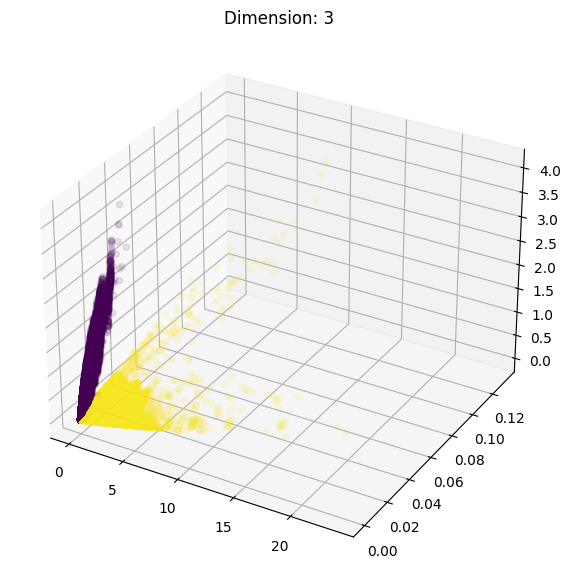

100%|█████████████████████████████████████████████| 1/1 [01:30<00:00, 90.82s/it]

time: 1min 30s (started: 2023-05-14 16:46:39 -05:00)


In [29]:
# Plot join
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

for dimension in tqdm(dimensions):
    # Read dataset
    df_edge_embeddings_join = pd.read_csv("{}/output_dgi/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, group[0], dimension, "L2"), index_col=0)

    x = df_edge_embeddings_join.iloc[:, 0]
    y = df_edge_embeddings_join.iloc[:, 1]
    z = df_edge_embeddings_join.iloc[:, 2]

    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    # Creating plot
    ax.scatter3D(x, y, z, c=df_edge_embeddings_join.iloc[:, -1], alpha=0.1)
    plt.title("Dimension: {}".format(dimension))

    # show plot
    plt.show()

### 5. Clustering

In [69]:
param_dist = { # No
    "min_samples": [10, 50, 100],
    "min_cluster_size":[100, 200, 300, 400, 500],  
    # "cluster_selection_method": ["eom", "leaf"],
    # "metric" : ["euclidean", "manhattan"]
}

min_cluster_sizes = [2, 4, 8, 16, 32, 64]
# dim. reduction: PCA, TSNE, UMAP

In [25]:
def cv_score(model, X): # No
    model.fit(X)
    labels = model.fit_predict(X)
    num_labels = len(list(labels))
    if num_labels == 1:
        # raise ValueError('number of labels must be greater than 2')
        print("Number of labels must be greater than 2")
    else:
        metric = silhouette_score(X, labels)
        # print("Metric: ", metric)
        return metric

time: 1.11 ms (started: 2023-05-12 09:31:21 -05:00)


In [ ]:
# Get best parameters (No)
from sklearn.model_selection import RandomizedSearchCV
import hdbscan

for dimension in tqdm(dimensions):
    df_edge_embeddings = pd.read_csv("{}/output_dgi/edge_embeddings_join/WT_edge-embeddings_join_{}_{}.csv".format(dir, dimension, "L2"), index_col=0)
    
    hdb = hdbscan.HDBSCAN()
    n_iter_search = 5
    random_search = RandomizedSearchCV(hdb, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=cv_score,
                                       n_jobs=8, random_state=42)

    random_search.fit(df_edge_embeddings.iloc[:, :-1])
    print("Best Parameters: ", random_search.best_params_)

In [19]:
# Get cluster (No)
for dimension in tqdm(dimensions):
    df_edge_embeddings = pd.read_csv("{}/output_dgi/edge_embeddings_join/WT_edge-embeddings_join_{}_{}.csv".format(dir, dimension, "L2"), index_col=0)
    
    X_train = df_edge_embeddings.iloc[:, [0, 1]]
    
    clustering = HDBSCAN(min_cluster_size=100, min_samples=100, core_dist_n_jobs=-1, 
                        allow_single_cluster=True)
    clustering.fit(df_edge_embeddings.iloc[:, :-1])
    X_train["labels"] = clustering.labels_

    # save
    X_train.to_csv("{}/output_dgi/cluster/WT_cluster_{}_{}.csv".format(dir, dimension, "L2"), index=True)


100%|████████████████████████████████████████| 1/1 [15:20<00:00, 920.77s/it]


In [ ]:
# silhouette_score(X_train.iloc[:, :-1], X_train.iloc[:, -1])

In [30]:
# Outlier detection

for dimension in tqdm(dimensions):
    df_edge_embeddings_join = pd.read_csv("{}/output_dgi/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, group[0], dimension, "L2"), index_col=0)
    
    X_train = df_edge_embeddings_join.iloc[:, :-1]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=100, core_dist_n_jobs=-1).fit(X_train)

100%|████████████████████████████████████████████| 1/1 [07:23<00:00, 443.35s/it]

time: 7min 23s (started: 2023-05-14 16:48:10 -05:00)


In [31]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

print(len(outliers))
outliers

604687


array([      0,       3,       9, ..., 6046860, 6046862, 6046863])

time: 12 s (started: 2023-05-14 16:55:33 -05:00)


6046865
604687
5290325


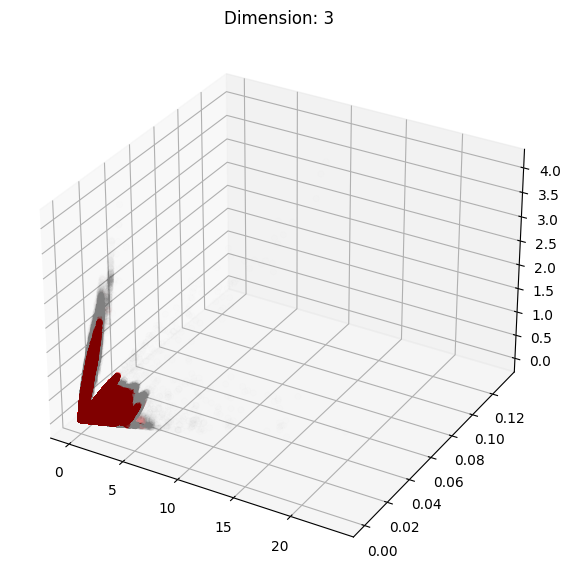

time: 1min 33s (started: 2023-05-14 16:55:45 -05:00)


In [32]:
print(len(df_edge_embeddings_join))
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

temp = df_edge_embeddings_join.iloc[outliers, :]
x = temp.iloc[:, 0]
y = temp.iloc[:, 1]
z = temp.iloc[:, 2]
ax.scatter3D(x, y, z, c="gray", alpha=0.005)
print(len(temp))

temp = df_edge_embeddings_join.drop(df_edge_embeddings_join.index[outliers])
x = temp.iloc[:, 0]
y = temp.iloc[:, 1]
z = temp.iloc[:, 2]
ax.scatter3D(x, y, z, c="red", alpha=0.005)
print(len(temp))

plt.title("Dimension: {}".format(dimension))
plt.show()

##### Short test

In [159]:
h = np.array([0, 2, 3])

In [160]:
df = pd.DataFrame({'x':np.random.randn(6), 'y':np.random.randn(6)}, index=["a" ,"b", "c" ,"d", "e", "a"])
print(len(df))
df

6


,x,y
a,1.267958,-0.777996
b,0.367999,0.643993
c,-0.065813,-0.076241
d,-0.370284,0.677894
e,-0.123623,-0.542217
a,0.424043,-1.818676


In [163]:
df.index.value_counts()

a    2
b    1
c    1
d    1
e    1
Name: count, dtype: int64

In [161]:
e = df.iloc[h, :]
print(len(e))
e

3


,x,y
a,1.267958,-0.777996
c,-0.065813,-0.076241
d,-0.370284,0.677894


In [162]:
d = df.drop(df.index[h])
print(len(d))
d

2


,x,y
b,0.367999,0.643993
e,-0.123623,-0.542217


###  Filter common edges

In [33]:
df_edge_embeddings_join_filter = df_edge_embeddings_join.drop(df_edge_embeddings_join.index[outliers])
df_edge_embeddings_join_filter.to_csv("{}/output_dgi/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index=True)
df_edge_embeddings_join_filter

,0,1,2,subgroup
"(0, 2)",0.001284,2.294346e-06,0.002085,1
"(0, 3)",0.002055,3.728568e-06,0.003333,1
"(0, 5)",0.000054,1.358070e-07,0.000086,1
"(0, 6)",0.002394,4.164416e-06,0.003894,1
"(0, 7)",0.000155,7.287300e-08,0.000266,1
...,...,...,...,...
"(6149, 6152)",1.093246,1.186073e-02,0.002970,2
"(6169, 6196)",0.000892,6.111481e-03,0.056495,2
"(6172, 6173)",0.005479,1.982702e-02,0.155009,2
"(6195, 6196)",0.104157,9.270479e-03,0.134304,2


time: 20.8 s (started: 2023-05-14 16:57:20 -05:00)


In [34]:
df_edge_embeddings_join_filter = pd.read_csv("{}/output_dgi/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index_col=0)
df_edge_embeddings_join_filter.set_index([pd.Index([eval(item) for item in df_edge_embeddings_join_filter.index])], inplace=True)
df_edge_embeddings_join_filter.to_csv("{}/output_dgi/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index=True)
df_edge_embeddings_join_filter

0             1         2  subgroup
0    2     0.001284  2.294346e-06  0.002085         1
     3     0.002055  3.728568e-06  0.003333         1
     5     0.000054  1.358070e-07  0.000086         1
     6     0.002394  4.164416e-06  0.003894         1
     7     0.000155  7.287300e-08  0.000266         1
...             ...           ...       ...       ...
6149 6152  1.093246  1.186073e-02  0.002970         2
6169 6196  0.000892  6.111481e-03  0.056495         2
6172 6173  0.005479  1.982702e-02  0.155009         2
6195 6196  0.104157  9.270479e-03  0.134304         2
6197 6210  0.902711  5.339804e-03  0.000692         2

[5290325 rows x 4 columns]

time: 52.8 s (started: 2023-05-14 16:57:41 -05:00)


In [35]:
df_edge_embeddings_join_filter = pd.read_csv("{}/output_dgi/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index_col=[0, 1])
df_edge_embeddings_join_filter

0             1         2  subgroup
0    2     0.001284  2.294346e-06  0.002085         1
     3     0.002055  3.728568e-06  0.003333         1
     5     0.000054  1.358070e-07  0.000086         1
     6     0.002394  4.164416e-06  0.003894         1
     7     0.000155  7.287300e-08  0.000266         1
...             ...           ...       ...       ...
6149 6152  1.093246  1.186073e-02  0.002970         2
6169 6196  0.000892  6.111481e-03  0.056495         2
6172 6173  0.005479  1.982702e-02  0.155009         2
6195 6196  0.104157  9.270479e-03  0.134304         2
6197 6210  0.902711  5.339804e-03  0.000692         2

[5290325 rows x 4 columns]

time: 2.12 s (started: 2023-05-14 16:58:33 -05:00)


In [78]:
df_nodes = pd.read_csv("{}/output_dgi/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], 1))
df_nodes

,idx,degree,ionMz
0,0,29,59.0049
1,1,114,99.9716
2,2,30,120.9310
3,3,106,172.0403
4,4,119,183.0464
...,...,...,...
6230,6230,2,901.7714
6231,6231,4,835.3027
6232,6232,5,835.3377
6233,6233,2,844.5313


time: 18.2 ms (started: 2023-05-14 12:09:23 -05:00)


In [36]:
# Mapping idx with ionMz
dict_df_nodes = {}
list_index = []
for i in tqdm(subgroups):
    df_nodes = pd.read_csv("{}/output_dgi/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], i))
    dict_df_nodes[i] = df_nodes

for dimension in tqdm(dimensions):
    df_edge_embeddings_join_filter = pd.read_csv("{}/output_dgi/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, group[0], 3, "L2"), index_col=[0, 1])

    for row in df_edge_embeddings_join_filter.itertuples():
        df_nodes = dict_df_nodes[str(row[-1])]        
        list_index.append((df_nodes.iloc[row[0][0], -1], df_nodes.iloc[row[0][1], -1]))

100%|████████████████████████████████████████████| 1/1 [02:24<00:00, 144.97s/it]

time: 2min 24s (started: 2023-05-14 16:58:36 -05:00)


In [37]:
# Set new index
df_edge_embeddings_join_filter.set_index([pd.Index(list_index)], inplace=True)
df_edge_embeddings_join_filter

0             1         2  subgroup
59.0049  120.9310  0.001284  2.294346e-06  0.002085         1
         172.0403  0.002055  3.728568e-06  0.003333         1
         192.0498  0.000054  1.358070e-07  0.000086         1
         210.0762  0.002394  4.164416e-06  0.003894         1
         227.9431  0.000155  7.287300e-08  0.000266         1
...                     ...           ...       ...       ...
731.2245 731.1490  1.093246  1.186073e-02  0.002970         2
637.2530 654.4398  0.000892  6.111481e-03  0.056495         2
829.9994 836.1700  0.005479  1.982702e-02  0.155009         2
585.1060 654.4398  0.104157  9.270479e-03  0.134304         2
655.3718 655.3228  0.902711  5.339804e-03  0.000692         2

[5290325 rows x 4 columns]

time: 2.1 s (started: 2023-05-14 17:01:01 -05:00)


In [38]:
# Count
temp = df_edge_embeddings_join_filter.index.value_counts().to_frame()
df_edge_embeddings_join_filter_count = temp[temp["count"] == len(subgroups)]
df_edge_embeddings_join_filter_count.to_csv("{}/output_dgi/edges_filter/{}_edges-filter-count_{}_{}.csv".format(dir, group[0], dimension, "L2"), index=True)
df_edge_embeddings_join_filter_count

count
265.1480 764.0502      2
319.2309 589.4467      2
         597.3792      2
         596.3795      2
         595.3766      2
...                  ...
808.1180 876.6106      2
147.0487 303.9522      2
351.2820 770.5828      2
806.4884 895.6138      2
415.3062 899.5209      2

[463628 rows x 1 columns]

time: 1.74 s (started: 2023-05-14 17:01:03 -05:00)


In [39]:
df_edge_embeddings_join_filter_count = pd.read_csv("{}/output_dgi/edges_filter/{}_edges-filter-count_{}_{}.csv".format(dir, group[0], 3, "L2"))
df_edge_embeddings_join_filter_count.columns = ["source", "target", "count"]
print(df_edge_embeddings_join_filter_count.info())
df_edge_embeddings_join_filter_count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463628 entries, 0 to 463627
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   source  463628 non-null  float64
 1   target  463628 non-null  float64
 2   count   463628 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 10.6 MB
None


,source,target,count
0,265.1480,764.0502,2
1,319.2309,589.4467,2
2,319.2309,597.3792,2
3,319.2309,596.3795,2
4,319.2309,595.3766,2
...,...,...,...
463623,808.1180,876.6106,2
463624,147.0487,303.9522,2
463625,351.2820,770.5828,2
463626,806.4884,895.6138,2


time: 86.3 ms (started: 2023-05-14 17:01:05 -05:00)


In [76]:
df_edges = pd.read_csv("{}/output_dgi/edges/{}_edges_{}.csv".format(dir, group[0], 2))
print(df_edges.info())
df_edges

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417355 entries, 0 to 4417354
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   source  float64
 1   target  float64
 2   weight  float64
dtypes: float64(3)
memory usage: 101.1 MB
None


,source,target,weight
0,59.0049,338.1873,0.507709
1,59.0049,357.2834,0.516811
2,59.0049,453.9675,0.507832
3,59.0049,587.1823,0.521553
4,59.0049,613.3933,0.516046
...,...,...,...
4417350,996.5509,997.5542,0.618624
4417351,996.5509,998.4845,0.678071
4417352,996.7096,997.5542,0.566913
4417353,997.5542,997.7131,0.589712


time: 917 ms (started: 2023-05-14 12:06:36 -05:00)


In [40]:
# Get weight
df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
s = []
t = []
for row in df_edge_embeddings_join_filter_count_weight.itertuples():
    if row[1] > row[2]:
        s.append(row[2])
        t.append(row[1])
    else:
        s.append(row[1])
        t.append(row[2])
df_edge_embeddings_join_filter_count_weight["source"] = s
df_edge_embeddings_join_filter_count_weight["target"] = t

# df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
df_edge_embeddings_join_filter_count_weight.sort_values(["source", "target"], ascending=True, inplace=True)
df_edge_embeddings_join_filter_count_weight["idx"] = df_edge_embeddings_join_filter_count_weight["source"].astype(str) + "-" + df_edge_embeddings_join_filter_count_weight["target"].astype(str)
list_aux = df_edge_embeddings_join_filter_count_weight.iloc[:, -1].values

for i in tqdm(subgroups):
    df_edges = pd.read_csv("{}/output_dgi/edges/{}_edges_{}.csv".format(dir, group[0], i))
    df_edges.sort_values(["source", "target"], ascending=True, inplace=True)
    df_edges["idx"] = df_edges["source"].astype(str) + "-" + df_edges["target"].astype(str)

    """ list_temp = []
    # for j in tqdm(range(len(df_edges_filter_count_weight))):
    for row in tqdm(df_edge_embeddings_join_filter_count_weight.itertuples()):
        # weight = 1 # df_edges[(df_edges["source"] == row[1]) & (df_edges["target"] == row[2])].iloc[0, -1]
        weight = df_edges[df_edges["idx"] == "{}-{}".format(row[1], row[2])].iloc[0, -2]
        list_temp.append(weight) """
    
    filter = df_edges["idx"].isin(list_aux)
    temp = df_edges[filter]
    list_temp = temp.iloc[:, -2].values
    df_edge_embeddings_join_filter_count_weight["subgroup{}".format(i)] = list_temp
df_edge_embeddings_join_filter_count_weight


100%|█████████████████████████████████████████████| 2/2 [00:09<00:00,  4.67s/it]


,source,target,count,idx,subgroup1,subgroup2
420013,59.0137,74.0249,2,59.0137-74.0249,0.756185,0.617955
420012,59.0137,78.9592,2,59.0137-78.9592,0.597487,0.746746
420011,59.0137,96.9602,2,59.0137-96.9602,0.828449,0.646446
420010,59.0137,96.9688,2,59.0137-96.9688,0.822159,0.684910
420009,59.0137,101.0243,2,59.0137-101.0243,0.567577,0.641071
...,...,...,...,...,...,...
421937,984.7590,987.7787,2,984.759-987.7787,0.538575,0.716540
422133,985.7644,987.7787,2,985.7644-987.7787,0.500747,0.556020
419469,986.7752,989.4484,2,986.7752-989.4484,0.527028,0.668604
419663,987.5639,990.5673,2,987.5639-990.5673,0.765752,0.633906


time: 10.2 s (started: 2023-05-14 17:01:05 -05:00)


In [97]:
df_edges = pd.read_csv("{}/output_dgi/edges/{}_edges_{}.csv".format(dir, group[0], 2))
df_edges[(df_edges["source"] == 986.7752) & (df_edges["target"] == 989.4484)].iloc[0, -1]

0.6686041901755109

time: 874 ms (started: 2023-05-14 12:32:30 -05:00)


In [41]:
# Dispersion (std)
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight.copy()
df_edge_embeddings_join_filter_count_weight_std["std"] = np.std(df_edge_embeddings_join_filter_count_weight_std.iloc[:, -len(subgroups):], axis=1)
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,std
420013,59.0137,74.0249,2,59.0137-74.0249,0.756185,0.617955,0.069115
420012,59.0137,78.9592,2,59.0137-78.9592,0.597487,0.746746,0.074630
420011,59.0137,96.9602,2,59.0137-96.9602,0.828449,0.646446,0.091002
420010,59.0137,96.9688,2,59.0137-96.9688,0.822159,0.684910,0.068625
420009,59.0137,101.0243,2,59.0137-101.0243,0.567577,0.641071,0.036747
...,...,...,...,...,...,...,...
421937,984.7590,987.7787,2,984.759-987.7787,0.538575,0.716540,0.088982
422133,985.7644,987.7787,2,985.7644-987.7787,0.500747,0.556020,0.027636
419469,986.7752,989.4484,2,986.7752-989.4484,0.527028,0.668604,0.070788
419663,987.5639,990.5673,2,987.5639-990.5673,0.765752,0.633906,0.065923


time: 76.2 ms (started: 2023-05-14 17:01:15 -05:00)


In [42]:
# Filter by std
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight_std[df_edge_embeddings_join_filter_count_weight_std["std"] <= 0.3]
df_edge_embeddings_join_filter_count_weight_std.to_csv("{}/output_dgi/edges_filter_weight_std/{}_edge-filter-weight-std_{}_{}.csv".format(dir, group[0], dimension, "L2"), index=False)
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,std
420013,59.0137,74.0249,2,59.0137-74.0249,0.756185,0.617955,0.069115
420012,59.0137,78.9592,2,59.0137-78.9592,0.597487,0.746746,0.074630
420011,59.0137,96.9602,2,59.0137-96.9602,0.828449,0.646446,0.091002
420010,59.0137,96.9688,2,59.0137-96.9688,0.822159,0.684910,0.068625
420009,59.0137,101.0243,2,59.0137-101.0243,0.567577,0.641071,0.036747
...,...,...,...,...,...,...,...
421937,984.7590,987.7787,2,984.759-987.7787,0.538575,0.716540,0.088982
422133,985.7644,987.7787,2,985.7644-987.7787,0.500747,0.556020,0.027636
419469,986.7752,989.4484,2,986.7752-989.4484,0.527028,0.668604,0.070788
419663,987.5639,990.5673,2,987.5639-990.5673,0.765752,0.633906,0.065923


time: 2.17 s (started: 2023-05-14 17:01:15 -05:00)


In [43]:
df_edge_embeddings_join_filter_count_weight_std = pd.read_csv("{}/output_dgi/edges_filter_weight_std/{}_edge-filter-weight-std_{}_{}.csv".format(dir, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,std
0,59.0137,74.0249,2,59.0137-74.0249,0.756185,0.617955,0.069115
1,59.0137,78.9592,2,59.0137-78.9592,0.597487,0.746746,0.074630
2,59.0137,96.9602,2,59.0137-96.9602,0.828449,0.646446,0.091002
3,59.0137,96.9688,2,59.0137-96.9688,0.822159,0.684910,0.068625
4,59.0137,101.0243,2,59.0137-101.0243,0.567577,0.641071,0.036747
...,...,...,...,...,...,...,...
414415,984.7590,987.7787,2,984.759-987.7787,0.538575,0.716540,0.088982
414416,985.7644,987.7787,2,985.7644-987.7787,0.500747,0.556020,0.027636
414417,986.7752,989.4484,2,986.7752-989.4484,0.527028,0.668604,0.070788
414418,987.5639,990.5673,2,987.5639-990.5673,0.765752,0.633906,0.065923


time: 400 ms (started: 2023-05-14 17:01:18 -05:00)


In [44]:
# Average weight
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std.copy()
df_edge_embeddings_join_filter_count_weight_std_avg["weight"] = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, -(len(subgroups) + 1):-1].mean(axis=1)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,count,idx,subgroup1,subgroup2,std,weight
0,59.0137,74.0249,2,59.0137-74.0249,0.756185,0.617955,0.069115,0.687070
1,59.0137,78.9592,2,59.0137-78.9592,0.597487,0.746746,0.074630,0.672116
2,59.0137,96.9602,2,59.0137-96.9602,0.828449,0.646446,0.091002,0.737447
3,59.0137,96.9688,2,59.0137-96.9688,0.822159,0.684910,0.068625,0.753535
4,59.0137,101.0243,2,59.0137-101.0243,0.567577,0.641071,0.036747,0.604324
...,...,...,...,...,...,...,...,...
414415,984.7590,987.7787,2,984.759-987.7787,0.538575,0.716540,0.088982,0.627558
414416,985.7644,987.7787,2,985.7644-987.7787,0.500747,0.556020,0.027636,0.528384
414417,986.7752,989.4484,2,986.7752-989.4484,0.527028,0.668604,0.070788,0.597816
414418,987.5639,990.5673,2,987.5639-990.5673,0.765752,0.633906,0.065923,0.699829


time: 74.5 ms (started: 2023-05-14 17:01:18 -05:00)


In [45]:
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, [0, 1, -1]]
df_edge_embeddings_join_filter_count_weight_std_avg.to_csv("{}/output_dgi/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, group[0], dimension, "L2"), index=False)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,59.0137,74.0249,0.687070
1,59.0137,78.9592,0.672116
2,59.0137,96.9602,0.737447
3,59.0137,96.9688,0.753535
4,59.0137,101.0243,0.604324
...,...,...,...
414415,984.7590,987.7787,0.627558
414416,985.7644,987.7787,0.528384
414417,986.7752,989.4484,0.597816
414418,987.5639,990.5673,0.699829


time: 1.14 s (started: 2023-05-14 17:01:18 -05:00)


In [46]:
df_edge_embeddings_join_filter_count_weight_std_avg = pd.read_csv("{}/output_dgi/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,59.0137,74.0249,0.687070
1,59.0137,78.9592,0.672116
2,59.0137,96.9602,0.737447
3,59.0137,96.9688,0.753535
4,59.0137,101.0243,0.604324
...,...,...,...
414415,984.7590,987.7787,0.627558
414416,985.7644,987.7787,0.528384
414417,986.7752,989.4484,0.597816
414418,987.5639,990.5673,0.699829


time: 133 ms (started: 2023-05-14 17:01:20 -05:00)


---

### Change detection (Greedy algorithm)

In [9]:
import matplotlib.pyplot as plt

def info_graph(G):
    print("Num. nodes: {}".format(G.number_of_nodes()))
    print("Num. edges: {}".format(G.number_of_edges()))
    print()

time: 413 µs (started: 2023-05-15 12:52:09 -05:00)


#### Read edges

In [10]:
df_edges1 = pd.read_csv("{}/output_dgi/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, "WT", 3, "L2"))
df_edges1[["source", "target"]] = df_edges1[["source", "target"]].astype(str)
df_edges1

,source,target,weight
0,59.0137,389.3284,0.791692
1,59.0137,391.2964,0.826840
2,59.0137,418.3254,0.877965
3,59.0137,419.3285,0.790765
4,59.0291,391.2964,0.701323
...,...,...,...
11196,952.6839,954.6629,0.694432
11197,953.6866,978.5819,0.676104
11198,969.6816,972.471,0.803943
11199,969.6816,979.5239,0.856486


time: 52.5 ms (started: 2023-05-15 12:52:09 -05:00)


In [11]:
G1 = nx.from_pandas_edgelist(df_edges1, "source", "target", edge_attr=["weight"])

time: 22.2 ms (started: 2023-05-15 12:52:09 -05:00)


In [12]:
# nx.draw_networkx(G1, pos=nx.spring_layout(G1), font_size=8, font_color="black")

time: 394 µs (started: 2023-05-15 12:52:09 -05:00)


In [13]:
df_edges2 = pd.read_csv("{}/output_dgi/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, "zwf1^", 3, "L2"))
df_edges2[["source", "target"]] = df_edges2[["source", "target"]].astype(str)
df_edges2

,source,target,weight
0,59.0137,124.0403,0.770148
1,59.0137,133.0501,0.786825
2,59.0137,134.0473,0.863013
3,59.0137,141.0173,0.806392
4,59.0137,145.0984,0.790925
...,...,...,...
360657,981.5305,986.7752,0.738430
360658,984.759,985.549,0.688567
360659,984.759,988.5664,0.626375
360660,985.549,985.7644,0.648868


time: 431 ms (started: 2023-05-15 12:52:10 -05:00)


In [14]:
G2 = nx.from_pandas_edgelist(df_edges2, "source", "target", edge_attr=["weight"])

time: 627 ms (started: 2023-05-15 12:52:10 -05:00)


In [15]:
# nx.draw_networkx(G2, pos=nx.spring_layout(G2), font_size=8, font_color="black")

time: 454 µs (started: 2023-05-15 12:52:11 -05:00)


In [16]:
df_edges3 = pd.read_csv("{}/output_dgi/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, "pck1^", 3, "L2"))
df_edges3[["source", "target"]] = df_edges3[["source", "target"]].astype(str)
df_edges3

,source,target,weight
0,59.0137,74.0249,0.687070
1,59.0137,78.9592,0.672116
2,59.0137,96.9602,0.737447
3,59.0137,96.9688,0.753535
4,59.0137,101.0243,0.604324
...,...,...,...
414415,984.759,987.7787,0.627558
414416,985.7644,987.7787,0.528384
414417,986.7752,989.4484,0.597816
414418,987.5639,990.5673,0.699829


time: 498 ms (started: 2023-05-15 12:52:11 -05:00)


In [17]:
G3 = nx.from_pandas_edgelist(df_edges3, "source", "target", edge_attr=["weight"])

time: 733 ms (started: 2023-05-15 12:52:12 -05:00)


#### Get common nodes

In [18]:
nodes1 = set(list(G1.nodes()))
# print(nodes1)

nodes2 = set(list(G2.nodes()))
# print(nodes2)

common_nodes = list(nodes1 & nodes2)
print("Length of common nodes:", len(common_nodes))

Length of common nodes: 1674
time: 1.85 ms (started: 2023-05-15 12:52:13 -05:00)


#### Get subgraphs

In [19]:
H1 = G1.subgraph(common_nodes)
H2 = G2.subgraph(common_nodes)

time: 2.34 ms (started: 2023-05-15 12:52:13 -05:00)


In [20]:
# nx.draw_networkx(H1, pos=nx.spring_layout(H1), font_color="w")

time: 398 µs (started: 2023-05-15 12:52:13 -05:00)


In [21]:
# nx.draw_networkx(H2, pos=nx.spring_layout(H2), font_color="w")

time: 403 µs (started: 2023-05-15 12:52:13 -05:00)


Get changes

In [22]:
def sort_edges(edges):
    edges = list(edges)
    for k in range(len(edges)):
        if edges[k][0] > edges[k][1]:
            edges[k] = (edges[k][1], edges[k][0])
    return edges

def degree_distibution(graps, labels=[]):
    list_hist = []
    for graph in graps:
        list_hist.append(list(dict(graph.degree()).values()))
    
    plt.hist(list_hist, label=labels)
    plt.legend(loc='upper center')

    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

time: 1.16 ms (started: 2023-05-15 12:52:13 -05:00)


In [23]:
edges1 = set(sort_edges(H1.edges()))
edges2 = set(sort_edges(H2.edges()))

# print(edges1)
# print(edges2)

e1_inte_e2 = edges1 & edges2
print(len(e1_inte_e2))
# print(list(e1_inte_e2))

e1_diff_e2 = edges1 - edges2
print(len(e1_diff_e2))
# print(list(e1_diff_e2))

e2_diff_e1 = edges2 - edges1
print(len(e2_diff_e1))
# print(list(e2_diff_e1))

2235
8485
106279
time: 501 ms (started: 2023-05-15 12:52:13 -05:00)


In [24]:
df_subgraphs = pd.DataFrame(e1_inte_e2, columns=["source", "target"])
df_subgraphs

,source,target
0,264.9055,358.8579
1,162.056,628.0561
2,633.4328,813.4851
3,689.4951,877.5208
4,688.4907,759.5518
...,...,...
2230,820.5671,901.5947
2231,267.0965,517.1517
2232,255.2332,714.4689
2233,306.1101,506.1877


time: 12.6 ms (started: 2023-05-15 12:52:14 -05:00)


In [25]:
df_subgraphs["weight1"] = df_subgraphs.apply(lambda x: H1.get_edge_data(x.source, x.target)["weight"], axis=1)
df_subgraphs["weight2"] = df_subgraphs.apply(lambda x: H2.get_edge_data(x.source, x.target)["weight"], axis=1)
df_subgraphs

,source,target,weight1,weight2
0,264.9055,358.8579,0.702577,0.888251
1,162.056,628.0561,0.785290,0.627830
2,633.4328,813.4851,0.850005,0.778677
3,689.4951,877.5208,0.738469,0.751602
4,688.4907,759.5518,0.810682,0.641725
...,...,...,...,...
2230,820.5671,901.5947,0.741332,0.674779
2231,267.0965,517.1517,0.713350,0.689213
2232,255.2332,714.4689,0.723103,0.794158
2233,306.1101,506.1877,0.818823,0.878159


time: 81.9 ms (started: 2023-05-15 12:52:14 -05:00)


In [26]:
list_subgraphs = []
for edge in e1_diff_e2:
    list_subgraphs.append([edge[0], edge[1], H1.get_edge_data(edge[0], edge[1])["weight"], np.nan])

for edge in e2_diff_e1:
    list_subgraphs.append([edge[0], edge[1], np.nan, H2.get_edge_data(edge[0], edge[1])["weight"]])

df_temp = pd.DataFrame(list_subgraphs, columns=["source", "target", "weight1", "weight2"])
df_subgraphs = pd.concat([df_subgraphs, df_temp])
df_subgraphs

,source,target,weight1,weight2
0,264.9055,358.8579,0.702577,0.888251
1,162.056,628.0561,0.785290,0.627830
2,633.4328,813.4851,0.850005,0.778677
3,689.4951,877.5208,0.738469,0.751602
4,688.4907,759.5518,0.810682,0.641725
...,...,...,...,...
114759,330.0704,505.1609,NaN,0.716583
114760,278.1847,980.0155,NaN,0.777074
114761,263.0973,798.0267,NaN,0.654707
114762,604.3977,686.4762,NaN,0.658939


time: 584 ms (started: 2023-05-15 12:52:14 -05:00)


In [27]:
df_subgraphs["difference"] = df_subgraphs["weight1"] - df_subgraphs["weight2"]
df_subgraphs["difference"] = df_subgraphs["difference"].abs()
df_subgraphs

,source,target,weight1,weight2,difference
0,264.9055,358.8579,0.702577,0.888251,0.185674
1,162.056,628.0561,0.785290,0.627830,0.157460
2,633.4328,813.4851,0.850005,0.778677,0.071328
3,689.4951,877.5208,0.738469,0.751602,0.013133
4,688.4907,759.5518,0.810682,0.641725,0.168957
...,...,...,...,...,...
114759,330.0704,505.1609,NaN,0.716583,NaN
114760,278.1847,980.0155,NaN,0.777074,NaN
114761,263.0973,798.0267,NaN,0.654707,NaN
114762,604.3977,686.4762,NaN,0.658939,NaN


time: 17.8 ms (started: 2023-05-15 12:52:15 -05:00)


In [28]:
# Add labels for correlaction changes
threshold2 = 0.8
conditions = [
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"].isnull()) & (df_subgraphs["weight1"] >= threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"].isnull()) & (df_subgraphs["weight1"] < threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"].isnull()) & (df_subgraphs["weight1"] >= threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"].isnull()) & (df_subgraphs["weight1"] < threshold2)),

    ((df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"].isnull()) & (df_subgraphs["weight2"] >= threshold2)),
    ((df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"].isnull()) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"].isnull()) & (df_subgraphs["weight2"] >= threshold2)),
    ((df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"].isnull()) & (df_subgraphs["weight2"] < threshold2)),

    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] > -threshold2) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] > -threshold2) & (df_subgraphs["weight2"] >= threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] <= -threshold2) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] <= -threshold2) & (df_subgraphs["weight2"] >= threshold2)),

    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] < threshold2) & (df_subgraphs["weight2"] > -threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] >= threshold2) & (df_subgraphs["weight2"] > -threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] < threshold2) & (df_subgraphs["weight2"] <= -threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] >= threshold2) & (df_subgraphs["weight2"] <= -threshold2)),

    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] >= threshold2) & (df_subgraphs["weight2"] >= threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] < threshold2) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] >= threshold2) & (df_subgraphs["weight2"] < threshold2)),
    ((df_subgraphs["weight1"] > 0) & (df_subgraphs["weight2"] > 0) & (df_subgraphs["weight1"] < threshold2) & (df_subgraphs["weight2"] >= threshold2)),

    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] <= -threshold2) & (df_subgraphs["weight2"] <= -threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] > -threshold2) & (df_subgraphs["weight2"] > -threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] <= -threshold2) & (df_subgraphs["weight2"] > -threshold2)),
    ((df_subgraphs["weight1"] < 0) & (df_subgraphs["weight2"] < 0) & (df_subgraphs["weight1"] > -threshold2) & (df_subgraphs["weight2"] <= -threshold2)),
]
# print(conditions)

values = ["N?", "n?", "P?", "p?", "?N", "?n", "?P", "?p", "np", "nP", "Np", "NP", "pn", "Pn", "pN", "PN", "PP", "pp", "Pp", "pP", "NN", "nn", "Nn", "nN"]
df_subgraphs["change"] = np.select(conditions, values)
df_subgraphs.to_csv("{}/output_dgi/subgraphs/{}_{}_subgraphs_{}_{}.csv".format(dir, "WT", "zwf1^", 3, "L2"), index=False)

df_subgraphs

,source,target,weight1,weight2,difference,change
0,264.9055,358.8579,0.702577,0.888251,0.185674,pP
1,162.056,628.0561,0.785290,0.627830,0.157460,pp
2,633.4328,813.4851,0.850005,0.778677,0.071328,Pp
3,689.4951,877.5208,0.738469,0.751602,0.013133,pp
4,688.4907,759.5518,0.810682,0.641725,0.168957,Pp
...,...,...,...,...,...,...
114759,330.0704,505.1609,NaN,0.716583,NaN,?p
114760,278.1847,980.0155,NaN,0.777074,NaN,?p
114761,263.0973,798.0267,NaN,0.654707,NaN,?p
114762,604.3977,686.4762,NaN,0.658939,NaN,?p


time: 350 ms (started: 2023-05-15 12:52:15 -05:00)


In [29]:
df_subgraphs = pd.read_csv("{}/output_dgi/subgraphs/{}_{}_subgraphs_{}_{}.csv".format(dir, "WT", "zwf1^", 3, "L2"))
df_subgraphs

,source,target,weight1,weight2,difference,change
0,264.9055,358.8579,0.702577,0.888251,0.185674,pP
1,162.0560,628.0561,0.785290,0.627830,0.157460,pp
2,633.4328,813.4851,0.850005,0.778677,0.071328,Pp
3,689.4951,877.5208,0.738469,0.751602,0.013133,pp
4,688.4907,759.5518,0.810682,0.641725,0.168957,Pp
...,...,...,...,...,...,...
116994,330.0704,505.1609,NaN,0.716583,NaN,?p
116995,278.1847,980.0155,NaN,0.777074,NaN,?p
116996,263.0973,798.0267,NaN,0.654707,NaN,?p
116997,604.3977,686.4762,NaN,0.658939,NaN,?p


time: 77.4 ms (started: 2023-05-15 12:52:15 -05:00)


In [30]:
H = nx.from_pandas_edgelist(df_subgraphs, "source", "target", edge_attr=["change"], create_using=nx.DiGraph())
H.edges(data=True)

print("WT")
info_graph(G1)

print("zwf1")
info_graph(G2)

print("pck1")
info_graph(G3)

print("Subgraph")
info_graph(H)

WT
Num. nodes: 1778
Num. edges: 11201

zwf1
Num. nodes: 4624
Num. edges: 360662

pck1
Num. nodes: 5089
Num. edges: 414420

Subgraph
Num. nodes: 1667
Num. edges: 116999

time: 267 ms (started: 2023-05-15 12:52:16 -05:00)


In [31]:
# nx.draw_networkx(H, pos=nx.spring_layout(H), font_color="w")

time: 388 µs (started: 2023-05-15 12:52:16 -05:00)


In [32]:
# degree_distibution([G1, G2, H], ["G1", "G2", "H"])

time: 199 µs (started: 2023-05-15 12:52:16 -05:00)


In [33]:
# sorted(H.degree, key=lambda x: x[1], reverse=True)

time: 371 µs (started: 2023-05-15 12:52:16 -05:00)


#### Filter and plot

{(356.103, 877.6205): Text(0.24999998137354879, 0.4330127121725851, '?P'),
 (356.103, 863.5636): Text(0.7499999590218074, -0.43301269296576733, '?p'),
 (587.3821, 863.5636): Text(0.4999999478459366, 2.4504569873240456e-08, 'PP'),
 (587.3821, 877.6205): Text(-2.9802321943606103e-08, 0.8660254296429223, '?p'),
 (283.3108,
  877.6205): Text(-0.49999996274709757, -5.297752070365647e-09, 'Pp'),
 (283.3108, 863.5636): Text(1.4901160971803051e-08, -0.8660254104361045, '?P'),
 (863.5636,
  877.6205): Text(-5.9604643887212205e-08, -5.297752070365647e-09, '?P')}

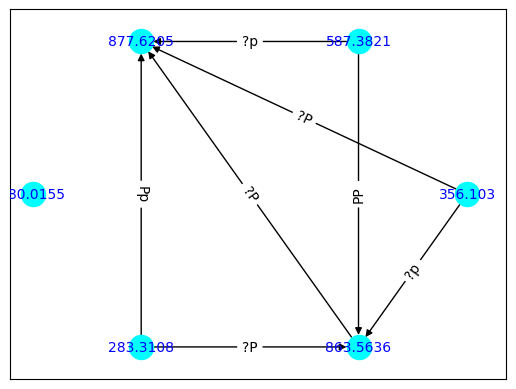

time: 202 ms (started: 2023-05-15 12:52:55 -05:00)


In [36]:
HF = H.subgraph([283.3108, 877.6205, 587.3821, 863.5636, 356.103, 980.0155])
edge_labels = nx.get_edge_attributes(HF, "change")

pos = pos=nx.circular_layout(HF)
nx.draw_networkx(HF, pos, font_color="blue", font_size=10, node_color="cyan")
nx.draw_networkx_edge_labels(H, pos, edge_labels)